In [ ]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers import PReLU
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
agentVisited = 0.8  # The cells that are visited by the agent will be painted
agentPos = 0.5      # The current agent cell will be painted
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# The actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

numActions = len(actions_dict)


epsilon = 0.1 # Exploration factor

In [ ]:
import numpy as np
import random

# Actions
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3

# Value to represent agent's position
agentPos = 0.5

class Qmaze(object):
    def __init__(self, maze, agent=(0, 0)):
        self.maz = np.array(maze)
        nrows, ncols = self.maz.shape
        self.target = (nrows-1, ncols-1)  # target cell
        self.empCells = [(r, c) for r in range(nrows) for c in range(ncols) if self.maz[r, c] == 1.0]
        self.nonEmpCells = [(r, c) for r in range(nrows) for c in range(ncols) if self.maz[r, c] == 0.0]
        self.empCells.remove(self.target)
        if self.maz[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not agent in self.empCells:
            raise Exception("Invalid agent Location: must sit on a free cell")
        self.reset(agent)

    def reset(self, agent):
        self.agent = agent
        #print(self.nonEmpCells)
        self.maze = np.copy(self.maz)
        nrows, ncols = self.maze.shape
        row, col = agent
        self.maze[row, col] = agentPos
        self.state = (row, col, 'start')
        self.minReward = -0.1 * self.maze.size
        self.totReward = 0
        self.visited = set()

    def updateState(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = agentRow, agentCol, mode = self.state

        if self.maze[agentRow, agentCol] > 0.0:
            self.visited.add((agentRow, agentCol))  # mark visited cell

        validActs = self.validActs()

        if not validActs:
            nmode = 'blocked'
        elif action in validActs:
            nmode = 'valid'
            if action == LEFT:
                self.maze[nrow,ncol]=1.0
                ncol -= 1
                self.maze[nrow,ncol]=0.5
            elif action == UP:
                self.maze[nrow,ncol]=1.0
                nrow -= 1
                self.maze[nrow,ncol]=0.5
            if action == RIGHT:
                self.maze[nrow,ncol]=1.0
                ncol += 1
                self.maze[nrow,ncol]=0.5
            elif action == DOWN:
                self.maze[nrow,ncol]=1.0
                nrow += 1
                self.maze[nrow,ncol]=0.5

        else:
            mode = 'invalid' # No change in agent position when in invalid position


        self.state = (nrow, ncol, nmode) # new state


# Function to calculate the reward
    def getReward(self):
        agentRow, agentCol, mode = self.state
        nrows, ncols = self.maze.shape
        if agentRow == nrows-1 and agentCol == ncols-1:
            return 1.0
        if mode == 'blocked':
            return self.minReward - 1
        if (agentRow, agentCol) in self.visited:
            return -0.25
        if mode == 'invalid':
            return -0.75
        if mode == 'valid':
            return -0.04

    def act(self, action):
        self.updateState(action)
        reward = self.getReward()
        self.totReward += reward
        status = self.gameStat()
        envstate = self.observe()
        nrows, ncols = self.maze.shape

        for not_free_cell in self.nonEmpCells:
                not_free_row, not_free_col = not_free_cell
                if not_free_row < nrows - 1:
                    if self.maze[not_free_row + 1, not_free_col]==1.0:
                        self.maze[not_free_row, not_free_col] = 1.0
                        self.maze[not_free_row + 1, not_free_col] = 0.0
                else:
                    if self.maze[0, not_free_col]==1.0:
                        self.maze[not_free_row, not_free_col] = 1.0
                        self.maze[0, not_free_col] = 0.0

        self.nonEmpCells = [(r, c) for r in range(nrows) for c in range(ncols) if self.maze[r, c] == 0.0]
        #print(self.nonEmpCells)
        print(self.maze)


        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        row, col, valid = self.state
        if valid == 'start':
            canvas[row, col] = agentPos

        return canvas

    def gameStat(self):
        if self.totReward < self.minReward:
            return 'lose'
        agentRow, agentCol, mode = self.state
        nrows, ncols = self.maze.shape
        if agentRow == nrows-1 and agentCol == ncols-1:
            return 'win'
        return 'not_over'

    def validActs(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [UP, DOWN, LEFT, RIGHT]
        nrows, ncols = self.maze.shape
        if row == 0:
            actions.remove(UP)
        elif row == nrows-1:
            actions.remove(DOWN)

        if col == 0:
            actions.remove(LEFT)
        elif col == ncols-1:
            actions.remove(RIGHT)

        if row > 0 and self.maze[row-1, col] == 0.0:
            actions.remove(UP)
        if row < nrows-1 and self.maze[row+1, col] == 0.0:
            actions.remove(DOWN)

        if col > 0 and self.maze[row, col-1] == 0.0:
            actions.remove(LEFT)
        if col < ncols-1 and self.maze[row, col+1] == 0.0:
            actions.remove(RIGHT)

        return actions


In [ ]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # Agent cell
    canvas[nrows-1, ncols-1] = 0.9 # Target cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [ ]:
maze = [
    [ 1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.],
]

[[1.  1.  0.  1. ]
 [0.5 0.  1.  1. ]
 [1.  1.  1.  1. ]
 [1.  1.  1.  1. ]]
reward= -0.04


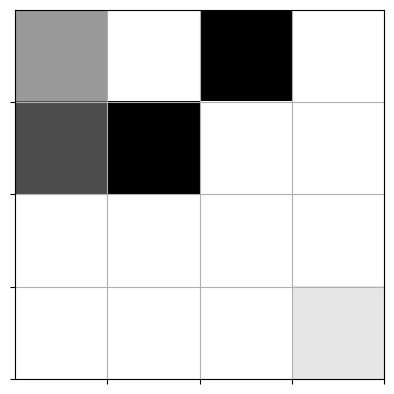

In [ ]:
qmaze = Qmaze(maze)
canvas, reward, gameOver = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

[[1.  1.  1.  1. ]
 [1.  1.  0.  1. ]
 [0.5 0.  1.  1. ]
 [1.  1.  1.  1. ]]
[[1.  1.  1.  1. ]
 [1.  1.  1.  1. ]
 [0.5 1.  0.  1. ]
 [1.  0.  1.  1. ]]
[[1.  0.  1.  1. ]
 [1.  1.  1.  1. ]
 [1.  0.5 1.  1. ]
 [1.  1.  0.  1. ]]
[[1.  1.  0.  1. ]
 [1.  0.  1.  1. ]
 [1.  1.  0.5 1. ]
 [1.  1.  1.  1. ]]
[[1.  1.  0.  1. ]
 [1.  1.  0.5 1. ]
 [1.  0.  1.  1. ]
 [1.  1.  1.  1. ]]


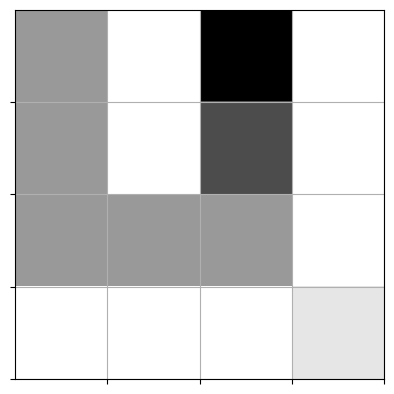

In [ ]:
qmaze.act(DOWN)  # move down
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(UP)  # move up
show(qmaze)

In [ ]:
def playGame(model, qmaze, agentCell):
    qmaze.reset(agentCell)
    envstate = qmaze.observe()
    while True:
        prevEnvstate = envstate
        # next action
        q = model.predict(prevEnvstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, gameStat = qmaze.act(action)
        if gameStat == 'win':
            return True
        elif gameStat == 'lose':
            return False

In [ ]:
def checkComplete(model, qmaze):
    for cell in qmaze.empCells:
        if not qmaze.validActs(cell):
            return False
        if not playGame(model, qmaze, cell):
            return False
    return True

In [ ]:
class Experience(object):
    def __init__(self, model, maxMemory=100, discount=0.95):
        self.model = model
        self.maxMemory = maxMemory
        self.discount = discount
        self.memory = list()
        self.numActions = model.output_shape[-1]

    def remember(self, episode):
        self.memory.append(episode)
        if len(self.memory) > self.maxMemory:
            del self.memory[0]

    def predict(self, envstate):
        return self.model.predict(envstate)[0]

    def getData(self, dataSize=10):
        envSize = self.memory[0][0].shape[1]   # envstate 1d size (1st element of episode)
        memSize = len(self.memory)
        dataSize = min(memSize, dataSize)
        inputs = np.zeros((dataSize, envSize))
        targets = np.zeros((dataSize, self.numActions))
        for i, j in enumerate(np.random.choice(range(memSize), dataSize, replace=False)):
            envstate, action, reward, envstateNxt, gameOver = self.memory[j]
            inputs[i] = envstate
            # There should be no target values for actions not taken.
            targets[i] = self.predict(envstate)
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = np.max(self.predict(envstateNxt))
            if gameOver:
                targets[i, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                targets[i, action] = reward + self.discount * Q_sa
        return inputs, targets

In [ ]:
loss_values = []
time_values = []
win_count = []
def qtrain(model, maze, **opt):
    global epsilon
    n_epoch = opt.get('n_epoch', 10)
    maxMemory = opt.get('maxMemory', 50)
    dataSize = opt.get('dataSize', 50)
    weightsFile = opt.get('weightsFile', "")
    name = opt.get('name', 'model')
    startTime = datetime.datetime.now()

    # If you want to continue  from a previous model,
    # just supply the h5 file natrainingme to weightsFile option
    if weightsFile:
        print("loading weights from file: %s" % (weightsFile,))
        model.load_weights(weightsFile)

    # Constructing the maze environment from numpy array
    qmaze = Qmaze(maze)

    # Initializing the experience replay object
    experience = Experience(model, maxMemory=maxMemory)

    winHistory = []   # storing the history of win or lose of the agent in the maze
    n_free_cells = len(qmaze.empCells)
    hsize = qmaze.maze.size // 2   # window size history
    winRate = 0.0
    imctr = 1

    for epoch in range(n_epoch):
        loss = 0.0
        agentCell = random.choice(qmaze.empCells)
        qmaze.reset(agentCell)
        gameOver = False

        # Getting the initial state of the environment (1d flattened canvas)
        envstate = qmaze.observe()

        n_episodes = 0
        while not gameOver:
            validActs = qmaze.validActs()
            if not validActs:
                break
            prevEnvstate = envstate

            # The action to be taken next
            if np.random.rand() < epsilon:
                action = random.choice(validActs)
            else:
                action = np.argmax(experience.predict(prevEnvstate))

            # Apply the action, get reward and new environment state
            envstate, reward, gameStat = qmaze.act(action)
            if gameStat == 'win':
                winHistory.append(1)
                gameOver = True
            elif gameStat == 'lose':
                winHistory.append(0)
                gameOver = True
            else:
                gameOver = False

            # Storing the episodes (agent storing experience)
            episode = [prevEnvstate, action, reward, envstate, gameOver]
            experience.remember(episode)
            n_episodes += 1

            # Training the neural network model
            inputs, targets = experience.getData(dataSize=dataSize)
            h = model.fit(
                inputs,
                targets,
                epochs=8,
                batch_size=16,
                verbose=0,
            )
            loss = model.evaluate(inputs, targets, verbose=2)
            loss_values.append(loss)

        if len(winHistory) > hsize:
            winRate = sum(winHistory[-hsize:]) / hsize



        dt = datetime.datetime.now() - startTime
        t = format_time(dt.total_seconds())
        win_count.append(winRate)
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(winHistory), winRate, t))

        # Here we check if the training has exhausted all the free cells and if in all the
        # cases the agent won
        if winRate > 0.9: epsilon = 0.05
        if sum(winHistory[-hsize:]) == hsize and checkComplete(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break

    # Saving the trained model weights and architecture, this will later be used by the visualization code
    h5file = name + ".h5"
    json_file = name + ".json"
    model.save_weights(h5file, overwrite=True)
    with open(json_file, "w") as outfile:
        json.dump(model.to_json(), outfile)
    end_time = datetime.datetime.now()
    dt = datetime.datetime.now() - startTime
    seconds = dt.total_seconds()
    t = format_time(seconds)
    time_values.append(t)
    print('files: %s, %s' % (h5file, json_file))
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, maxMemory, dataSize, t))
    return seconds

# Function to print the readable time strings
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

In [ ]:
def build_model(maze, lr=0.001):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(numActions))
    model.compile(optimizer='adam', loss='mse')
    return model

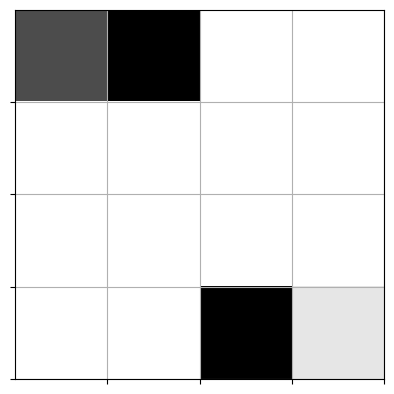

In [ ]:
maze =  np.array([
    [ 1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.],
])

qmaze = Qmaze(maze)
show(qmaze)

In [ ]:
model = build_model(maze)
qtrain(model, maze, epochs=8, maxMemory=8*maze.size, dataSize=32)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 32ms/step
1/1 - 0s - loss: 0.0014 - 34ms/epoch - 34ms/step
1/1 [==============================] - 0s 36ms/step
[[1.  0.5 0.  1. ]
 [1.  1.  1.  1. ]
 [1.  1.  0.  1. ]
 [1.  0.  1.  1. ]]
1/1 [==============================] - 0s 21ms/step
1/1 - 0s - loss: 0.0011 - 20ms/epoch - 20ms/step
1/1 [==============================] - 0s 21ms/step
[[1.  0.5 1.  1. ]
 [1.  1.  0.  1. ]
 [1.  1.  1.  1. ]
 [1.  0.  0.  1. ]]
1/1 [==============================] - 0s 34ms/step
1/1 - 0s - loss: 0.0017 - 30ms/epoch - 30ms/step
1/1 [==============================] - 0s 33ms/step
[[1.  0.  0.5 1. ]
 [1.  1.  1.  1. ]
 [1.  1.  0.  1. ]
 [1.  1.  0.  1. ]]
1/1 [==============================] - 0s 22ms/step
1/1 - 0s - loss: 0.0012 - 20ms/epoch - 20ms/step
1/1 [==============================] - 0s 26ms/step
[[1.  1.  0.  0.5]
 [1.  0.  1.  1. ]
 [1.  1.  0.  1. ]
 [1.  1.  1.  1. ]]
1/1 [========================

622.724169

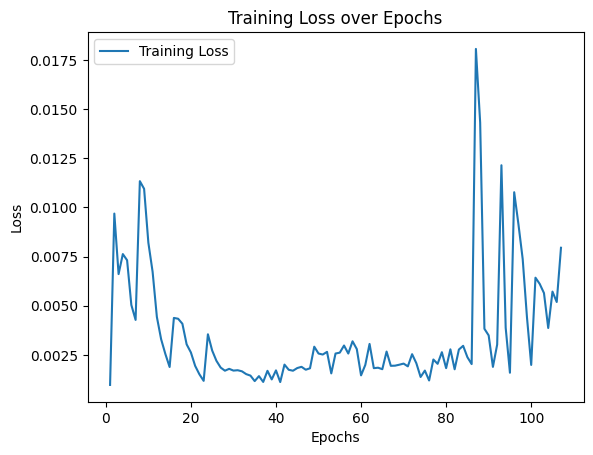

In [ ]:
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

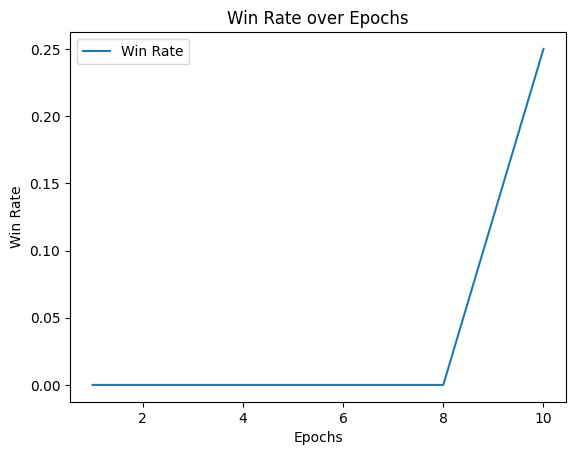

In [ ]:
# win_rate_values = [0.500, 0.375, 0, 0, 0, 0, 0, 0, 0]
epochs = range(1, len(win_count) + 1)

plt.plot(epochs, win_count, label='Win Rate')
plt.title('Win Rate over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Win Rate')
plt.legend()
plt.show()